In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12528689876366278171
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 15816295547648520087
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 6899358827783827094
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 1568518798954334399
physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 10975051776
locality {
  bus_id: 1
}
incarnation: 10560819997963978995
physical_device_desc: "device: 3, name: G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [3]:
cd /media/datastorage/Phong/fashion_mnist

/media/datastorage/Phong/fashion_mnist


In [4]:
## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


Using TensorFlow backend.


In [5]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

In [4]:
#SET 1

from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, GRU, Reshape, Concatenate,Bidirectional
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f2_base = senet(input_shape=(299,299,3), weights='imagenet', include_top=False)
f2_x = GlobalAveragePooling2D()(f2_base.output)

f2_x = Reshape([1,2048])(f2_x)  
f2_x = GRU(2048, 
            return_sequences=False,                       
#             dropout=0.8                                     
            input_shape=[1,2048])(f2_x)

# # #Regularization with noise
f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(10, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# # print(f2_base.summary())

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
conv2d_298 (Conv2D)             (None, 19, 19, 16)   2304        lambda_269[0][0]                 
__________________________________________________________________________________________________
conv2d_299 (Conv2D)             (None, 19, 19, 16)   2304        lambda_270[0][0]                 
__________________________________________________________________________________________________
conv2d_300 (Conv2D)             (None, 19, 19, 16)   2304        lambda_271[0][0]                 
__________________________________________________________________________________________________
conv2d_301 (Conv2D)             (None, 19, 19, 16)   2304        lambda_272[0][0]                 
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 19, 19, 16)   2304        lambda_273[0][0]                 
__________

conv2d_567 (Conv2D)             (None, 19, 19, 16)   2304        lambda_517[0][0]                 
__________________________________________________________________________________________________
conv2d_568 (Conv2D)             (None, 19, 19, 16)   2304        lambda_518[0][0]                 
__________________________________________________________________________________________________
conv2d_569 (Conv2D)             (None, 19, 19, 16)   2304        lambda_519[0][0]                 
__________________________________________________________________________________________________
conv2d_570 (Conv2D)             (None, 19, 19, 16)   2304        lambda_520[0][0]                 
__________________________________________________________________________________________________
conv2d_571 (Conv2D)             (None, 19, 19, 16)   2304        lambda_521[0][0]                 
__________________________________________________________________________________________________
conv2d_572

                                                                 conv2d_861[0][0]                 
                                                                 conv2d_862[0][0]                 
                                                                 conv2d_863[0][0]                 
                                                                 conv2d_864[0][0]                 
                                                                 conv2d_865[0][0]                 
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 19, 19, 512)  2048        concatenate_24[0][0]             
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 19, 19, 512)  0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
conv2d_866

In [7]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                

In [10]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 4
batch_size = 40
#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/40
1499/1500 [============================>.] - ETA: 1s - loss: 0.4996 - acc: 0.8212
Saving val_acc 0.896900 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_GRU.pkl
1500/1500 [==============================] - 1680s 1s/step - loss: 0.4994 - acc: 0.8213 - val_loss: 0.2813 - val_acc: 0.8969
Epoch 2/40
1499/1500 [============================>.] - ETA: 1s - loss: 0.3260 - acc: 0.8834
Saving val_acc 0.908000 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_GRU.pkl
1500/1500 [==============================] - 1625s 1s/step - loss: 0.3260 - acc: 0.8834 - val_loss: 0.2457 - val_acc: 0.9080
Epoch 3/40
1499/1500 [============================>.] - ETA: 1s - loss: 0.2831 - acc: 0.8975
Saving val_acc 0.921400 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_GRU.pkl
1500/1500 [==============================] - 1623s 1s/step - loss: 0.2831 - acc: 0.8975 - val_loss: 0.2132 - val_acc: 0.9214
Epoch 

In [ ]:
mkdir checkpoints

In [18]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# #use set_weights to load the modelweights into the model architecture
# NUM_GPU = 4
# #Using multiple models if more than 1 GPU
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [19]:
# Change LR=1e-5

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 4
batch_size = 40

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU_L2.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/15
1499/1500 [============================>.] - ETA: 1s - loss: 0.0639 - acc: 0.9761
Saving val_acc 0.953800 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_GRU_L2.pkl
1500/1500 [==============================] - 1696s 1s/step - loss: 0.0639 - acc: 0.9761 - val_loss: 0.1695 - val_acc: 0.9538
Epoch 2/15
1500/1500 [==============================] - 1621s 1s/step - loss: 0.0525 - acc: 0.9807 - val_loss: 0.1766 - val_acc: 0.9527
Epoch 3/15
1500/1500 [==============================] - 1620s 1s/step - loss: 0.0487 - acc: 0.9821 - val_loss: 0.1786 - val_acc: 0.9520
Epoch 4/15
1500/1500 [==============================] - 1620s 1s/step - loss: 0.0479 - acc: 0.9828 - val_loss: 0.1809 - val_acc: 0.9530
Epoch 5/15
1500/1500 [==============================] - 1618s 1s/step - loss: 0.0441 - acc: 0.9843 - val_loss: 0.1889 - val_acc: 0.9520
Epoch 6/15
1500/1500 [==============================] - 1618s 1

In [15]:
max(result.history['val_acc']),min(result.history['val_acc'])

(0.9529000024795532, 0.9514000039100647)

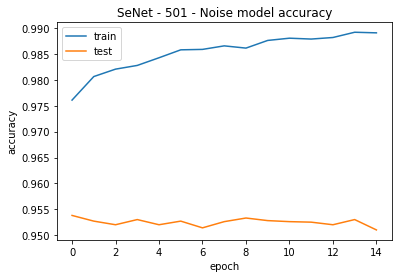

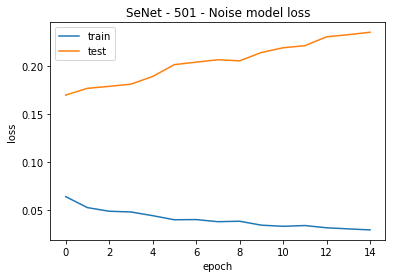

In [20]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('SeNet - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('SeNet - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU_L2.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#use set_weights to load the modelweights into the model architecture
NUM_GPU = 4
#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [13]:
# Change LR=1e-6

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 4
batch_size = 40

epochs = 10##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU_L3.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/10
1499/1500 [============================>.] - ETA: 1s - loss: 0.0524 - acc: 0.9811
Saving val_acc 0.954000 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_GRU_L3.pkl
1500/1500 [==============================] - 1701s 1s/step - loss: 0.0525 - acc: 0.9810 - val_loss: 0.1708 - val_acc: 0.9540
Epoch 2/10
1500/1500 [==============================] - 1621s 1s/step - loss: 0.0521 - acc: 0.9809 - val_loss: 0.1699 - val_acc: 0.9540
Epoch 3/10
1500/1500 [==============================] - 1624s 1s/step - loss: 0.0527 - acc: 0.9813 - val_loss: 0.1709 - val_acc: 0.9533
Epoch 4/10
1500/1500 [==============================] - 1624s 1s/step - loss: 0.0524 - acc: 0.9812 - val_loss: 0.1715 - val_acc: 0.9534
Epoch 5/10
1500/1500 [==============================] - 1624s 1s/step - loss: 0.0515 - acc: 0.9818 - val_loss: 0.1728 - val_acc: 0.9537
Epoch 6/10
1500/1500 [==============================] - 1623s 1

In [14]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_GRU_L3.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# #use set_weights to load the modelweights into the model architecture
# NUM_GPU = 4
# #Using multiple models if more than 1 GPU
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [15]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 40

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_GRU_2810_01.csv')
results.head()

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
250/250 [==============================] - 118s 472ms/step


,file_name,predicted1
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0


In [ ]:
results.tail()

In [ ]:
cp FashionMNIST_SeResNet101_MulModels299_2310_01.csv /home/bribeiro/Phong/Nat19/FashionMNIST_SeResNet101_MulModels299_2310_01.csv

In [16]:
np.save(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_GRU_Mul.npy'), predict1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 30

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (320, 320),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 299)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 21
predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
    if NUM_GPU != 1:
        preds=model_mul.predict_generator(test_crops, 
                                           steps = step_size_test_crop,
#                                            max_queue_size=16,
#                                                use_multiprocessing=True,
#                                            workers=1,
                                           verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
#     preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv')
results.head(10)

In [ ]:
cp FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv /home/bribeiro/Phong/Nat19/FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv

In [ ]:
# Save weights in pickle format instead of h5
import pickle

#use get_weights() command to get your model weights
weigh= model_2.get_weights()

#now, use pickle to save your model weights, instead of .h5
#for heavy model architectures, .h5 file is unsupported.
pklfile= os.path.join('checkpoints', 'Cassava_NonGrp_Set1_SEResNext101_LRG501_Mul_STD.pkl')

fpkl= open(pklfile, 'wb') #Python 3
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

In [ ]:
os.listdir("checkpoints")

In [ ]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#use set_weights to load the modelweights into the model architecture
NUM_GPU = 3

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [ ]:
model_mul.save_weights(savedfilename)
f2_sgl = model_mul.layers[-2]
f2_sgl.save(os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG450_Mul_Pretrained_STD_L3_SGL.hdf5'))

In [ ]:
len(model_mul.to_json())

In [ ]:
np.asarray([layer.name.encode('utf8') for layer in model_mul.layers]).nbytes

In [ ]:
len(model_2.to_json())

In [ ]:
np.asarray([layer.name.encode('utf8') for layer in model_2.layers]).nbytes

In [ ]:
#Set 1
#MUL 1 - Xception

# from keras.applications import InceptionV3
from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, Reshape, Bidirectional
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.xception import preprocess_input

from keras.layers import GaussianNoise

f1_base = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))  
f1_x = f1_base.output
f1_x = GlobalAveragePooling2D()(f1_x)

f1_x = Reshape([1,2048])(f1_x)  
f1_x = Bidirectional(LSTM(1024, 
                                 return_sequences=False, 
#                                  dropout=0.8
                                ),
                            input_shape=[1,2048],
                            merge_mode='concat')(f1_x)

#Regularization with noise
f1_x = GaussianNoise(0.1)(f1_x)

f1_x = Dense(2048, activation='relu')(f1_x)
f1_x = Dense(10, activation='softmax')(f1_x)
model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

print(model_1.summary())

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 100

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
import matplotlib.pyplot as plt
history = result
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul.hdf5'))

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L2.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
#Using multiple models if more than 1 GPU
NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L2.hdf5'))

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 100

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L3.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True
earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

epochs = 15##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
import numpy as np

print(result.history['val_acc'])
print(np.mean(result.history['val_acc']))
print(np.max(result.history['val_acc']))

print(result.history['acc'])
print(np.mean(result.history['acc']))
print(np.max(result.history['acc']))

In [ ]:
#Using multiple models if more than 1 GPU
NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L3.hdf5'))

In [ ]:
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_2410_01.csv')
results.head()

In [ ]:
mkdir pred_npy

In [ ]:
np.save(os.path.join('pred_npy','FashionMNIST_Xception_LRG299_Mul.npy'), predict1)

In [ ]:
mkdir checkpoints

In [ ]:
#501
#MUL 3 InceptionResNetV2
# from keras.applications import InceptionV3
# from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

f3_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))  
# for layer in f3_base.layers:
#     layer.trainable = False 
f3_x = f3_base.output
f3_x = GlobalAveragePooling2D()(f3_x)

#Regularization with noise
f3_x = GaussianNoise(0.1)(f3_x)

f3_x = Dense(2048, activation='relu')(f3_x)
f3_x = Dense(10, activation='softmax')(f3_x)
model_3 = Model(inputs=[f3_base.input],outputs=[f3_x])

print(model_3.summary())

In [ ]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 120

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_3, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

In [ ]:
#Using multiple models if more than 1 GPU
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul.hdf5'))

In [ ]:
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########
epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

In [ ]:
#Using multiple models if more than 1 GPU
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5'))

In [ ]:
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L3.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########
epochs = 5##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

In [ ]:
#Using multiple models if more than 1 GPU
import os

NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_3, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5'))

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 120

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_IcpResNetV2_MulModels299_2510_01.csv')
results.head()

In [ ]:
np.save(os.path.join('pred_npy','FashionMNIST_IcpResNetV2_LRG299_Mul.npy'), predict1)

In [ ]:
mean_pred3_1 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_Mul.npy'))
mean_pred3_2 = np.load(os.path.join('pred_npy','FashionMNIST_Xception_LRG299_Mul.npy'))
mean_pred3_3 = np.load(os.path.join('pred_npy','FashionMNIST_IcpResNetV2_LRG299_Mul.npy'))
mean_pred3 = (mean_pred3_1+mean_pred3_2+mean_pred3_3)/3
print(mean_pred3[0:9])

In [ ]:
mean_pred3_1 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_Mul.npy'))
mean_pred3_2 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_GRU_Mul.npy'))
mean_pred3_3 = np.load(os.path.join('pred_npy','FashionMNIST_IcpResNetV2_LRG299_Mul.npy'))
mean_pred3 = (mean_pred3_1+mean_pred3_2+mean_pred3_3)/3
print(mean_pred3[0:9])

In [20]:
mean_pred3_1 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_Mul.npy'))
mean_pred3_2 = np.load(os.path.join('pred_npy','FashionMNIST_Xception_LRG299_Mul.npy'))
mean_pred3_3 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_GRU_Mul.npy'))
mean_pred3 = (mean_pred3_1+mean_pred3_2+mean_pred3_3)/3
print(mean_pred3[0:9])

[[9.9999887e-01 2.8780658e-12 7.2562187e-07 1.6085225e-07 3.8642704e-11
  2.9256103e-13 2.3256337e-07 2.0677067e-15 2.3550731e-10 4.3913462e-12]
 [9.9940568e-01 1.2167073e-11 1.8012774e-06 2.3323355e-07 2.8320766e-09
  2.1617623e-12 5.9226860e-04 6.8059877e-14 2.9432536e-09 8.3303815e-11]
 [9.9999005e-01 3.8686459e-13 1.5773560e-08 1.2452560e-09 1.6428334e-09
  1.0301522e-12 9.9144281e-06 1.8396971e-14 6.0074598e-11 2.0690144e-11]
 [1.0000000e+00 4.2726311e-15 8.8012070e-10 1.4914069e-10 1.2488297e-13
  3.2994777e-15 2.5379547e-09 5.9921212e-18 1.6368444e-13 2.3424613e-14]
 [9.9999970e-01 1.2538246e-14 5.8760556e-09 2.0852688e-09 1.6627985e-11
  1.4549748e-14 3.3748037e-07 1.6122043e-17 4.5932415e-13 7.5909195e-14]
 [1.0000000e+00 4.7416444e-14 4.1517008e-09 4.7402021e-10 6.4128772e-12
  5.9611532e-15 3.1003207e-08 2.9507266e-17 1.9040334e-12 8.9561096e-14]
 [1.0000000e+00 1.3420660e-15 6.1900984e-11 6.4474365e-10 3.7437738e-14
  1.0298707e-15 9.1261887e-09 3.3546161e-18 1.2694820e-13 

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 40

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

train_datagen = ImageDataGenerator(

)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )
        
test_datagen_crop = ImageDataGenerator(
)

testing_set_crop = test_datagen_crop.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 299)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

predicted_class_indices_mean=np.argmax(mean_pred3,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('FashionMNIST_MulModels299_AVG_Assembe_2810_2.csv')
results.head(20)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


,id,predicted
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0
5,0/00085.png,0
6,0/00088.png,0
7,0/00096.png,0
8,0/00113.png,0
9,0/00120.png,0


In [22]:
cp FashionMNIST_MulModels299_AVG_Assembe_2810_2.csv /home/bribeiro/Phong/Nat19/FashionMNIST_MulModels299_AVG_Assembe_2810_2.csv

In [ ]:
model_1.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Xception_LRG501_Mul_Pretrained_STD_SGL.hdf5'))
# model_2.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Inception_LRG501_Mul_Pretrained_STD_SGL.hdf5'))
model_3.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_IcpResNetV2_LRG501_Mul_Pretrained_STD_SGL.hdf5'))

In [ ]:
# 3 models
# 501
# pre-trainned weight
# get pretrained [-1] layer

from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, LeakyReLU, Dropout
#from keras.applications.inception_v3 import preprocess_input
from keras_applications.imagenet_utils import preprocess_input

f1_mul_x = model_1.layers[-1].output 
f2_mul_x = model_2.layers[-1].output
f3_mul_x = model_3.layers[-1].output

x = concatenate([f1_mul_x, f2_mul_x, f3_mul_x])

x = Dense(4096)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model_mul = Model(inputs=[model_1.get_input_at(0),model_2.get_input_at(0),model_3.get_input_at(0)],outputs=[x])

print(model_mul.summary())

In [ ]:
for layer in model_mul.layers[:-4]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_mul.layers):
    print(i,layer.name,layer.trainable)

In [ ]:
# generators for three inputs
def train_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, seed=1, target_size = (501, 501))    
    while True:
        X1i = genX1.next()
        yield [X1i[0], X1i[0], X1i[0]], X1i[1]
        
def valid_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator()

    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, seed=1, target_size = (501, 501))        
    while True:
        X1i = genX1.next()
        yield [X1i[0], X1i[0], X1i[0]], X1i[1]    
    
def test_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator(
#         preprocessing_function=preprocess_input
    )

    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, shuffle=False, target_size = (501, 501))        
    while True:
        X1i_0, X1i_1 = next(genX1)
        yield [X1i_0, X1i_0, X1i_0]            

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 120

training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_LRG501_Mul_Pretrained_SeNet_Xcep_IcpRes_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=False)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_mul, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# else:
#     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(training_set.n/training_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1)    

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v1.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v1.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v1.csv

In [ ]:
#MULTI GPUS

from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator_three_models(batches, crop_length):
    """Generate random crops from the image batches"""
     
    while True:
        batch_x, _ = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield [batch_crops, batch_crops, batch_crops]

gen = ImageDataGenerator(
#     rescale = 1./255,
#         preprocessing_function=preprocess_input
)

genX1 = gen.flow_from_directory('test',
                                 target_size = (541, 541),
                                 batch_size = batch_size,
                                 class_mode = 'categorical',
                                 shuffle=False,
                                 seed=7,
                              )

#steps
step_size_test_crop = ceil(genX1.n/genX1.batch_size)

#customized generator
test_crops = crop_generator_three_models(genX1, 501)

#number of crops
tta_steps = 7
# predictions = []

for i in range(tta_steps):
    print('iteration = %d' %i)
    #reset index
    genX1.reset()
    
    preds=model_mul.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v5.csv')
results.head(11)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v5.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v5.csv

In [ ]:
import pickle

#use get_weights() command to get your model weights
weigh= model_mul.get_weights()

#now, use pickle to save your model weights, instead of .h5
#for heavy model architectures, .h5 file is unsupported.
pklfile= os.path.join('checkpoints', 'Cassava_NonGrp_S1_LRG501_Mul_Pretrained_STD_09076.pkl')

fpkl= open(pklfile, 'wb') #Python 3
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

In [ ]:
#use pickle to load model weights

pklfile= os.path.join('checkpoints', 'Cassava_NonGrp_S1_LRG501_Mul_Pretrained_STD_09076.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

gpus_model_mul = multi_gpu_model(model_mul, gpus=NUM_GPU)
#use set_weights to load the modelweights into the model architecture
gpus_model_mul.set_weights(weigh)

In [ ]:
epochs = 50##!!!

result = model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1)    

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v6.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v6.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v6.csv

In [ ]:
epochs = 10##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.91, verbose=1)

result = model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.913, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=gpus_model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v8.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v8.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v8.csv

In [ ]:
#MULTI GPUS

from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator_three_models(batches, crop_length):
    """Generate random crops from the image batches"""
     
    while True:
        batch_x, _ = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield [batch_crops, batch_crops, batch_crops]

gen = ImageDataGenerator(
#     rescale = 1./255,
#         preprocessing_function=preprocess_input
)

genX1 = gen.flow_from_directory('test',
                                 target_size = (541, 541),
                                 batch_size = batch_size,
                                 class_mode = 'categorical',
                                 shuffle=False,
                                 seed=7,
                              )

#steps
step_size_test_crop = ceil(genX1.n/genX1.batch_size)

#customized generator
test_crops = crop_generator_three_models(genX1, 501)

#number of crops
tta_steps = 5
predictions = []

for i in range(tta_steps):
    print('iteration = %d / %d' %(i+1,tta_steps))
    #reset index
    genX1.reset()
    
    preds=gpus_model_mul.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v10.csv')
results.head(11)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v10.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v11.csv

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.919, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=gpus_model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v12.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v12.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v12.csv

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

# lr = 1e-5
# decay = lr/epochs
lr = 1e-6
decay = 0
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.925, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#seresnext50
#Non-Groups
#Split training and validation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 20

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG501_Mul_Pretrained_STD_L4.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8870, verbose=1)##!!!!!!

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping],
    verbose=1) 

In [ ]:
#0.8898756673450369
#0.8827708640911651
max(result.history['val_acc'])

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('SeNet50 - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('SeNet50 - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_mul.save_weights(savedfilename)

In [ ]:
model_mul.save_weights(savedfilename)
f2_sgl = model_mul.layers[-2]
f2_sgl.save(os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG450_Mul_Pretrained_STD_L3_SGL.hdf5'))

In [ ]:
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (450, 450),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (450, 450),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels450_2108_v1.csv')
results.head()

In [ ]:
cp Cassava_NonGrp_MulModels450_2108_v1.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels450_2108_v1.csv

In [ ]:
model_2.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG450_Mul_Pretrained_STD_L3_SGL.hdf5'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 20

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('test',
                                                 target_size = (500, 500),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 450)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 3
predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
#     if NUM_GPU != 1:
#         preds=mul_model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
    preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels450_2108_v3.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels450_2108_v3.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels450_2108_v3.csv

In [ ]:
result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

nasnet, preprocess_input = Classifiers.get('senet154')

f4_base = nasnet(input_shape=(501,501,3), weights=None, include_top=False)

f4_x = GlobalAveragePooling2D()(f4_base.output)

# # #Regularization with noise
f4_x = GaussianNoise(0.1)(f4_x)

f4_x = Dense(2048, activation='relu')(f4_x)
f4_x = Dense(5, activation='softmax')(f4_x)
model_4 = Model(inputs=[f4_base.input],outputs=[f4_x])

print(model_4.summary())
# # print(f2_base.summary())

In [ ]:
ls -l

In [ ]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('Cassava_NonGrp_S1_SENet154_LRG501_STD.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# restoredmodel= mymodel()
#use set_weights to load the modelweights into the model architecture
model_4.set_weights(weigh)

In [ ]:
for layer in model_4.layers[:-4]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_4.layers):
    print(i,layer.name,layer.trainable)

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 80

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_SENet154_LRG501_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8850, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_4, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
!wget https://github.com/qubvel/classification_models/releases/download/0.0.1/senet154_imagenet_1000_no_top.h5

In [ ]:
mv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl 

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

nasnet, preprocess_input = Classifiers.get('nasnetlarge')

f4_base = nasnet(input_shape=(501,501,3), weights=None, include_top=False)

f4_x = GlobalAveragePooling2D()(f4_base.output)

# # #Regularization with noise
f4_x = GaussianNoise(0.1)(f4_x)

f4_x = Dense(2048, activation='relu')(f4_x)
f4_x = Dense(5, activation='softmax')(f4_x)
model_4 = Model(inputs=[f4_base.input],outputs=[f4_x])

print(model_4.summary())
# # print(f2_base.summary())

In [ ]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# restoredmodel= mymodel()
#use set_weights to load the modelweights into the model architecture
model_4.set_weights(weigh)

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 12

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8850, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_4, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
#MUL 2 - Inception
#501
import keras

# from keras_applications.resnext import ResNeXt101, preprocess_input
# from keras.applications.resnet50 import ResNet50
# from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from classification_models.senet import SEResNet101, preprocess_input
# from classification_models.keras import Classifiers


from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

# ResNext101, preprocess_input = Classifiers.get('resnext101')
# NASNetLarge = preprocess_input = Classifiers.get('nasnetlarge')

# SENet154, preprocess_input = Classifiers.get('senet154')

f2_base = SEInceptionResNetV2(include_top=True,
                        weights=None,
                        input_tensor=None,
                        input_shape=(501,501,3),
                        pooling=None)

# # f2_base = Classifiers.get('nasnetlarge')[0]((501, 501, 3), weights=None)
# f2_base = SENet154((501, 501, 3), weights=None)
# # f2_base = SeNet154((501,501,3), weights = 'imagenet', include_top=False) 
# # f2_base = ResNext101((501,501,3), weights = 'imagenet') 
# # # f2_base = NASNetLarge((501,501,3), weights = 'imagenet')

# # # for layer in f3_base.layers:
# # #     layer.trainable = False 
f2_x = f2_base.layers[-2].output
# # # f2_x = GlobalAveragePooling2D()(f2_x)

# # #Regularization with noise
# f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(5, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# print(f2_base.summary())

In [ ]:
!pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
print(pretrainedmodels.model_names)

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f2_base = senet(input_shape=(501,501,3), weights='imagenet', include_top=False)
f2_x = GlobalAveragePooling2D()(f2_base.output)

# # #Regularization with noise
f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(5, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# # print(f2_base.summary())

In [ ]:
for layer in model_2.layers[:-3]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_2.layers):
    print(i,layer.name,layer.trainable)

In [ ]:
from keras.utils import to_categorical
import numpy as np
import random
import csv
import glob
import os
import os.path

def get_data():
    """Load data from file."""
    with open(os.path.join('cassava_data_senet.csv'), 'r') as fin:
        reader = csv.reader(fin)
        data = list(reader)

    return data

def get_extracted_sequence(sample):
    """Get the extracted features."""
    filename = sample[0] + '_' + sample[1] + '_' + sample[2]
    path = os.path.join('sequences', filename + '.npy')
    #print(path)
    if os.path.isfile(path):
        return np.load(path)
    else:
        return None
    
def get_classes():
    """Extract the classes from data"""
    classes = []
    for item in data:
        if item[1] not in classes:
            classes.append(item[1])

    # Sort them.
    classes = sorted(classes)

    # Return.
    return classes

def get_class_one_hot(class_str):
    """Encode and one-hot classes for training.
    Given a class as a string, return its number in the classes list. """
    # Encode
    label_encoded = classes.index(class_str)

    # One-hot
    label_hot = to_categorical(label_encoded, len(classes))

    assert len(label_hot) == len(classes)

    return label_hot

def get_all_sequences_in_memory(train_test):
    """
    Load everything into memory
    """
    # Get the right dataset.
    train, test = split_train_test()
    data = train if train_test == 'train' else test
    
    print("Loading %d samples into memory for %sing." % (len(data), train_test))
    
    X, y = [], []
    for row in data:
        sequence = get_extracted_sequence(row)
        # modify for single sequence
        sequence = np.expand_dims(sequence, axis=0)

        if sequence is None:
            print("Can't find sequence?")
            raise

        X.append(sequence)
        y.append(get_class_one_hot(row[1]))

    return np.array(X), np.array(y)

def split_train_test():
    """Split the data into train and test sets."""
    train = []
    test = []
    for item in data:
        if item[0] == 'train':
            train.append(item)
        else:
            test.append(item)
    return train, test

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f3_base = senet(input_shape=(501,501,3), weights='imagenet', include_top=False)
f3_x = GlobalAveragePooling2D()(f3_base.output)

# # # #Regularization with noise
# f2_x = GaussianNoise(0.1)(f2_x)

# f2_x = Dense(2048, activation='relu')(f2_x)
# f2_x = Dense(5, activation='softmax')(f2_x)
model_3 = Model(inputs=[f3_base.input],outputs=[f3_x])

print(model_3.summary())
# # print(f2_base.summary())

In [ ]:
from keras.preprocessing import image as imgload
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
import numpy as np

class Extractor_SeNet():
    def __init__(self, weights=None):

        # assign model_1 (Xception)
        self.model = model_3
            
    def extract(self, image_path):
        img = imgload.load_img(image_path, target_size=(501, 501)) #input size
        #img = imgload.load_img(image_path, target_size=(224, 224)) #densenet, mobilenet
        x = imgload.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Get the prediction.
        features = self.model.predict(x)

#         if self.weights is None:
#             # For imagenet/default network:
#             features = features[0]
#         else:
#             # For loaded network:
#             features = features[0]

        return features[0]

In [ ]:
mv sequences sequences_bkp

In [ ]:
rm -r sequences

In [ ]:
mkdir sequences

In [ ]:
# Feature Extraction
#

import numpy as np
import os.path
from tqdm import tqdm
import sys
import os

import csv
import glob
import os
import os.path

# Get model
model = Extractor_SeNet()

# Multiple GPUs
NUM_GPU = 4
model.model = multi_gpu_model(model.model, gpus=NUM_GPU)

# Load weights
# model.model.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Xception_LRG501_Mul_Pretrained_STD.hdf5'))

# Get the dataset.
data = get_data()
print(len(data))

# Get the model.
# model = Extractor_InceptionV3()

# Loop through data.
pbar = tqdm(total=len(data))
for images in data:
    feature_path = os.path.join('sequences', images[0] + '_' + images[1] + '_' + images[2])

    # Skip if the file already existed.
    if os.path.isfile(feature_path + '.npy'):
        pbar.update(1)
        continue

    image_path = os.path.join(images[0], images[1], images[2])
    feature = model.extract(image_path)

    # Save the feature.
    np.save(feature_path, feature)
    
    pbar.update(1)

pbar.close()

In [ ]:
from keras.utils import to_categorical
import numpy as np
import random

def get_extracted_sequences_one_model(dir1, sample):
    """Get the extracted features."""
    filename = sample[0] + '_' + sample[1] + '_' + sample[2]
    path1 = os.path.join(dir1, filename + '.npy')
    #print(path)
    if os.path.isfile(path1):
        return np.load(path1)
    else:
        return None
    
def get_all_sequences_one_model_in_memory(dir1, train_test):
    """
    Load everything into memory
    """
    # Get the right dataset.
    train, test = split_train_test()
    data = train if train_test == 'train' else test
    
    print("Loading %d samples into memory for %sing." % (len(data), train_test))
    
    X, y = [], []
    for row in data:
        sequence1 = get_extracted_sequences_one_model(dir1, row)
        
        # add two sequences
#         sequence = np.concatenate(sequence1, axis=0)
        # modify for single sequence
        sequence = np.expand_dims(sequence1, axis=0)

        if sequence is None:
            print("Can't find sequence?")
            raise

        X.append(sequence)
        y.append(get_class_one_hot(row[1]))

    return np.array(X), np.array(y)

In [ ]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, LeakyReLU
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)

def base_line_one_model():
    """Build a simple model"""
    # Model.
    model = Sequential()
#     model.add(Dense(32, input_shape=(16,)))
    model.add(Flatten(input_shape=(1,2048)))
#     model.add(Dense(1024, activation='relu'))#inceptionv3
#     model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
senet_model = base_line_one_model()
senet_model.summary()

In [ ]:
# Get the dataset.
data = get_data()
print(len(data))

# Get the classes.
classes = get_classes()
print(classes)

In [ ]:
#3 models
#IcpResNet, Inception, Xception
#501

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import time, os

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_TL_SeNet501_Mul_Pretrained_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=False)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

early_stopper = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)


X_train, y_train = get_all_sequences_one_model_in_memory('sequences','train')
X_valid, y_valid = get_all_sequences_one_model_in_memory('sequences','valid')

from keras.optimizers import Adam

NUM_GPU = 4
batch_size = 60
nb_epoch = 500

lr = 1e-5
decay = lr/nb_epoch
optimizer = Adam(lr=lr, decay=decay)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    mul_model = multi_gpu_model(senet_model, gpus=NUM_GPU)

if NUM_GPU != 1:
    mul_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = mul_model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            verbose=1,
            callbacks=[tb, csv_logger, checkpointer, early_stopper],
            epochs=nb_epoch)

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Cassava - TL - 3M Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Cassava - TL - 3M Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)
model.summary()

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=True)
model.summary()